# Imports and PyTorch Device

In [2]:
# Import Packages
!pip install gymnasium
import gym
import numpy as np
from numpy.typing import NDArray
from typing import List, Tuple, Deque, Optional, Callable
import time
import torch
from torch.optim.lr_scheduler import _LRScheduler
from tqdm.notebook import tqdm
import collections
import gymnasium as gym
import itertools
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import random
import time
import torch
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Tuple, Deque, Optional, Callable
import seaborn as sns
import sys, subprocess
import heapq
import math

def is_colab():
    return "google.colab" in sys.modules

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

if is_colab():
    run_subprocess_command("apt install swig xvfb x11-utils")
    run_subprocess_command("pip install gymnasium[box2d] pyvirtualdisplay cma")
# To display GIF images in the notebook

import imageio     # To render episodes in GIF images (otherwise there would be no render on Google Colab)
                   # C.f. https://stable-baselines.readthedocs.io/en/master/guide/examples.html#bonus-make-a-gif-of-a-trained-agent
import IPython
from IPython.display import Image

if is_colab():
    import pyvirtualdisplay

    _display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                        size=(1400, 900))
    _ = _display.start()

class RenderWrapper:
    def __init__(self, env, force_gif=False):
        self.env = env
        self.force_gif = force_gif
        self.reset()

    def reset(self):
        self.images = []

    def render(self):
        if not is_colab():
            self.env.render()
            time.sleep(1./60.)

        if is_colab() or self.force_gif:
            img = self.env.render()         # Assumes env.render_mode == 'rgb_array'
            self.images.append(img)

    def make_gif(self, filename="render"):
        if is_colab() or self.force_gif:
            imageio.mimsave(filename + '.gif', [np.array(img) for i, img in enumerate(self.images) if i%2 == 0], fps=29, loop=0)
            return Image(open(filename + '.gif','rb').read())

    @classmethod
    def register(cls, env, force_gif=False):
        env.render_wrapper = cls(env, force_gif=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 swig4.0 x11-xkb-utils xfonts-base
xfonts-encodings xfonts-utils xserver-common
Suggested packages:
swig-doc swig-examples swig4.0-examples swig4.0-doc mesa-utils
The following NEW packages will be installed:
libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 swig swig4.0 x11-utils x11-xkb-utils
xfonts-base xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 14 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,161 kB of archives.
After this operation, 18.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.

In [3]:

# Setup PyTorch Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to CUDA if available, otherwise use CPU
print(f"PyTorch will train neural networks on {device}")

PyTorch will train neural networks on cuda


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class EpsilonGreedy:
    """
    An Epsilon-Greedy policy.

    Attributes
    ----------
    epsilon : float
        The initial probability of choosing a random action.
    epsilon_min : float
        The minimum probability of choosing a random action.
    epsilon_decay : float
        The decay rate for the epsilon value after each action.
    env : gym.Env
        The environment in which the agent is acting.
    q_network : torch.nn.Module
        The Q-Network used to estimate action values.

    Methods
    -------
    __call__(state: np.ndarray) -> np.int64
        Select an action for the given state using the epsilon-greedy policy.
    decay_epsilon()
        Decay the epsilon value after each action.
    """

    def __init__(self,
                 epsilon_start: float,
                 epsilon_min: float,
                 epsilon_decay:float,
                 env: gym.Env,
                 q_network: torch.nn.Module):
        """
        Initialize a new instance of EpsilonGreedy.

        Parameters
        ----------
        epsilon_start : float
            The initial probability of choosing a random action.
        epsilon_min : float
            The minimum probability of choosing a random action.
        epsilon_decay : float
            The decay rate for the epsilon value after each episode.
        env : gym.Env
            The environment in which the agent is acting.
        q_network : torch.nn.Module
            The Q-Network used to estimate action values.
        """
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:
        """
        Select an action for the given state using the epsilon-greedy policy.

        If a randomly chosen number is less than epsilon, a random action is chosen.
        Otherwise, the action with the highest estimated action value is chosen.

        Parameters
        ----------
        state : np.ndarray
            The current state of the environment.

        Returns
        -------
        np.int64
            The chosen action.
        """

        # TODO...

        if np.random.rand() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            # print('Inside Epsilon Greedy:', state.shape)
            state = np.expand_dims(state, axis=0)
            q_vals = self.q_network(torch.tensor(state, dtype=torch.float32).to(device)).to(device)
            action = q_vals.argmax().item()

        return action

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [5]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        """
        Initialize a new instance of MinimumExponentialLR.

        Parameters
        ----------
        optimizer : torch.optim.Optimizer
            The optimizer whose learning rate should be scheduled.
        lr_decay : float
            The multiplicative factor of learning rate decay.
        last_epoch : int, optional
            The index of the last epoch. Default is -1.
        min_lr : float, optional
            The minimum learning rate. Default is 1e-6.
        """
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler.

        Returns
        -------
        List[float]
            The learning rates of each parameter group.
        """
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

In [6]:
class ReplayBuffer:
    """
    A Replay Buffer.

    Attributes
    ----------
    buffer : collections.deque
        A double-ended queue where the transitions are stored.

    Methods
    -------
    add(state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool)
        Add a new transition to the buffer.
    sample(batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]
        Sample a batch of transitions from the buffer.
    __len__()
        Return the current size of the buffer.
    """

    def __init__(self, capacity: int):
        """
        Initializes a ReplayBuffer instance.

        Parameters
        ----------
        capacity : int
            The maximum number of transitions that can be stored in the buffer.
        """
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool):
        """
        Add a new transition to the buffer.

        Parameters
        ----------
        state : np.ndarray
            The state vector of the added transition.
        action : np.int64
            The action of the added transition.
        reward : float
            The reward of the added transition.
        next_state : np.ndarray
            The next state vector of the added transition.
        done : bool
            The final state of the added transition.
        """
        # print(type(state))
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]:
        """
        Sample a batch of transitions from the buffer.

        Parameters
        ----------
        batch_size : int
            The number of transitions to sample.

        Returns
        -------
        Tuple[np.ndarray, float, float, np.ndarray, bool]
            A batch of `batch_size` transitions.
        """
        # Here, `random.sample(self.buffer, batch_size)`
        # returns a list of tuples `(state, action, reward, next_state, done)`
        # where:
        # - `state`  and `next_state` are numpy arrays
        # - `action` and `reward` are floats
        # - `done` is a boolean
        #
        # `states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))`
        # generates 5 tuples `state`, `action`, `reward`, `next_state` and `done`, each having `batch_size` elements.
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        # for i in range(len(states)):
        #     print(type(states[i]))
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns
        -------
        int
            The current size of the buffer.
        """
        return len(self.buffer)

In [7]:
def test_q_network_agent(env: gym.Env, q_network: torch.nn.Module, num_episode: int = 1, render: bool = True) -> List[int]:
    """
    Test a naive agent in the given environment using the provided Q-network.

    Parameters
    ----------
    env : gym.Env
        The environment in which to test the agent.
    q_network : torch.nn.Module
        The Q-network to use for decision making.
    num_episode : int, optional
        The number of episodes to run, by default 1.
    render : bool, optional
        Whether to render the environment, by default True.

    Returns
    -------
    List[int]
        A list of rewards per episode.
    """
    episode_reward_list = []

    for episode_id in range(num_episode):

        state, info = env.reset()
        done = False
        episode_reward = 0

        while not done:
            if render:
                env.render_wrapper.render()
            # Convert the state to a PyTorch tensor and add a batch dimension (unsqueeze)
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            # TODO...
            action = torch.argmax(q_network(state_tensor)).item()

            next_state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            state = next_state

        episode_reward_list.append(episode_reward)
        print(f"Episode reward: {episode_reward}")

    return episode_reward_list

# DQN

In [8]:
class QNetwork(torch.nn.Module):
    """
    A Q-Network implemented with PyTorch.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        First fully connected layer.
    layer2 : torch.nn.Linear
        Second fully connected layer.
    layer3 : torch.nn.Linear
        Third fully connected layer.

    Methods
    -------
    forward(x: torch.Tensor) -> torch.Tensor
        Define the forward pass of the QNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int, nn_l1: int, nn_l2: int):
        """
        Initialize a new instance of QNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        nn_l1 : int
            The number of neurons on the first layer.
        nn_l2 : int
            The number of neurons on the second layer.
        """
        super(QNetwork, self).__init__()

        # TODO...

        self.l1 = torch.nn.Linear(n_observations, nn_l1)
        self.l2 = torch.nn.Linear(nn_l1, nn_l2)
        self.final_layer = torch.nn.Linear(nn_l2, n_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass of the QNetwork.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor (state).

        Returns
        -------
        torch.Tensor
            The output tensor (Q-values).
        """

        # TODO...

        x = x.to(device)
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        x = self.final_layer(x)

        return x

In [9]:
def train_dqn_agent(env: gym.Env,
                     q_network: torch.nn.Module,
                     target_q_network: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     loss_fn: Callable,
                     epsilon_greedy: EpsilonGreedy,
                     device: torch.device,
                     lr_scheduler: _LRScheduler,
                     num_episodes: int,
                     gamma: float,
                     batch_size: int,
                     replay_buffer: ReplayBuffer,
                     target_q_network_sync_period: int) -> List[float]:
    """
    Train the Q-network on the given environment.

    Parameters
    ----------
    env : gym.Env
        The environment to train on.
    q_network : torch.nn.Module
        The Q-network to train.
    target_q_network : torch.nn.Module
        The target Q-network to use for estimating the target Q-values.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    loss_fn : callable
        The loss function to use for training.
    epsilon_greedy : EpsilonGreedy
        The epsilon-greedy policy to use for action selection.
    device : torch.device
        The device to use for PyTorch computations.
    lr_scheduler : torch.optim.lr_scheduler._LRScheduler
        The learning rate scheduler to adjust the learning rate during training.
    num_episodes : int
        The number of episodes to train for.
    gamma : float
        The discount factor for future rewards.
    batch_size : int
        The size of the batch to use for training.
    replay_buffer : ReplayBuffer
        The replay buffer storing the experiences with their priorities.
    target_q_network_sync_period : int
        The number of episodes after which the target Q-network should be updated with the weights of the Q-network.

    Returns
    -------
    List[float]
        A list of cumulated rewards per episode.
    """
    iteration = 0
    episode_reward_list = []

    for episode_index in tqdm(range(1, num_episodes)):
        state, info = env.reset()
        episode_reward = 0

        for t in itertools.count():

            # Get action, next_state and reward

            action = epsilon_greedy(state)

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            replay_buffer.add(state, action, reward, next_state, done)

            episode_reward += reward

            # Update the q_network weights with a batch of experiences from the buffer

            if len(replay_buffer) > batch_size:
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = replay_buffer.sample(batch_size)

                # Convert to PyTorch tensors
                batch_states_tensor = torch.tensor(batch_states, dtype=torch.float32, device=device)
                batch_actions_tensor = torch.tensor(batch_actions, dtype=torch.long, device=device)
                batch_rewards_tensor = torch.tensor(batch_rewards, dtype=torch.float32, device=device)
                batch_next_states_tensor = torch.tensor(batch_next_states, dtype=torch.float32, device=device)
                batch_dones_tensor = torch.tensor(batch_dones, dtype=torch.float32, device=device)

                # TODO...
                # Q-values
                q_vals = q_network(batch_states_tensor)
                # q_vals = q_vals.gather(1, batch_actions_tensor.unsqueeze(1)).squeeze(1)

                # Target Q-values
                next_q_vals = target_q_network(batch_next_states_tensor)
                max_next_q_vals = torch.max(next_q_vals, dim=1).values.unsqueeze(1)
                target_q_vals = batch_rewards_tensor.unsqueeze(1) + gamma * (1 - batch_dones_tensor.unsqueeze(1)) * max_next_q_vals

                loss = loss_fn(q_vals, target_q_vals.detach())

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                lr_scheduler.step()

            # Update the target q-network

            # Every few training steps (e.g., every 100 steps), the weights of the target network are updated with the weights of the Q-network

            # TODO...

            if iteration % target_q_network_sync_period == 0:
                target_q_network.load_state_dict(q_network.state_dict())

            iteration += 1


            state = next_state

            if done:
                break


        episode_reward_list.append(episode_reward)
        epsilon_greedy.decay_epsilon()

    return episode_reward_list

In [10]:
env = gym.make('LunarLander-v2')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n.item()

dqn_trains_result_list = [[], [], []]

NUMBER_OF_TRAININGS = 5
for train_index in range(NUMBER_OF_TRAININGS):

    # Instantiate required objects

    # TODO...
    q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
    target_q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)

    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn_agent(env,
                                           q_network,
                                           target_q_network,
                                           optimizer,
                                           loss_fn,
                                           epsilon_greedy,
                                           device,
                                           lr_scheduler,
                                           num_episodes=300,
                                           gamma=0.9,
                                           batch_size=128,
                                           replay_buffer=replay_buffer,
                                           target_q_network_sync_period=30)
    dqn_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn_trains_result_list[1].extend(episode_reward_list)
    dqn_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn_trains_result_df = pd.DataFrame(np.array(dqn_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn_trains_result_df["agent"] = "DQN 2015"

# Save the action-value estimation function

torch.save(q_network, "dqn_q_network.pth")

env.close()

  0%|          | 0/299 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.f

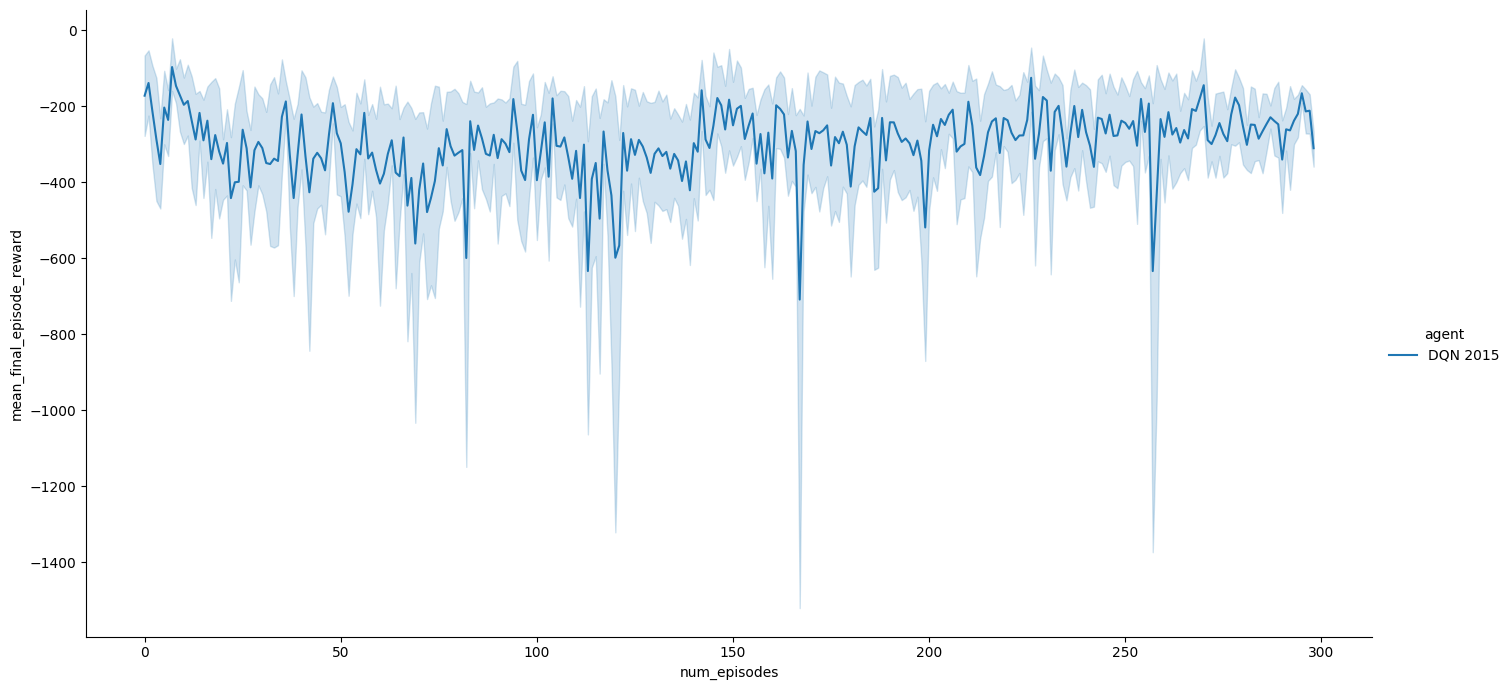

In [11]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=dqn_trains_result_df, height=7, aspect=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode reward: -239.3252539620474
Episode reward: -369.85324937725227
Episode reward: -293.0444173589236
Episode reward: -159.0856275251017
Episode reward: -206.24861985490014


/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


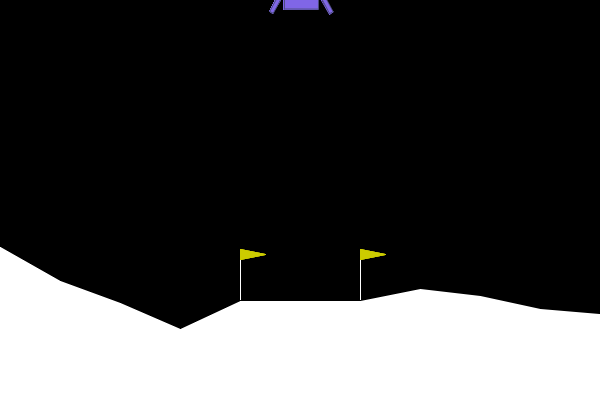

In [12]:
# q_network = torch.load("naive_q_network.pth").to(device)

env = gym.make('LunarLander-v2', render_mode = 'rgb_array')
RenderWrapper.register(env, force_gif=True)

test_q_network_agent(env, q_network, num_episode=5)

env.close()

env.render_wrapper.make_gif("dqn_2015")

# Dueling Double DQN

In [13]:
class DuelingQNetwork(torch.nn.Module):
    def __init__(self, n_observations, n_actions, nn_l1, nn_l2):
        super(DuelingQNetwork, self).__init__()

        self.feature_layer = torch.nn.Linear(n_observations, nn_l1)

        # Value stream
        self.value_stream = torch.nn.Sequential(
            torch.nn.Linear(nn_l1, nn_l2),
            torch.nn.ReLU(),
            torch.nn.Linear(nn_l2, 1)  # Output is the value of the state
        )

        # Advantage stream
        self.advantage_stream = torch.nn.Sequential(
            torch.nn.Linear(nn_l1, nn_l2),
            torch.nn.ReLU(),
            torch.nn.Linear(nn_l2, n_actions)  # Output is the advantage of each action
        )

    def forward(self, x):
        # print('Inside Q Network:', x.shape)
        x = x.to(device)
        x = torch.relu(self.feature_layer(x)).to(device)

        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        # Combine the value and advantage streams
        # print(type(advantage))
        # print(advantage.shape)
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))

        return q_values


In [14]:
def train_dddqn_agent(env: gym.Env,
                                   q_network: DuelingQNetwork,
                                   target_q_network: DuelingQNetwork,
                                   optimizer: torch.optim.Optimizer,
                                   loss_fn: Callable,
                                   epsilon_greedy: EpsilonGreedy,
                                   device: torch.device,
                                   lr_scheduler: torch.optim.lr_scheduler._LRScheduler,
                                   num_episodes: int,
                                   gamma: float,
                                   batch_size: int,
                                   replay_buffer: ReplayBuffer,
                                   freq_update: int = 10) -> List[float]:
    episode_rewards = []

    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = epsilon_greedy(state)
            next_state, reward, done, _, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                states = torch.tensor(states, dtype=torch.float32).to(device)
                actions = torch.tensor(actions).unsqueeze(1).to(device)
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
                next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
                dones = torch.tensor(dones, dtype=torch.uint8).unsqueeze(1).to(device)

                # Compute current Q values
                current_q_vals = q_network(states).gather(1, actions)

                # Double DQN update
                next_actions = q_network(next_states).argmax(dim=1, keepdim=True)
                next_q_vals = target_q_network(next_states).gather(1, next_actions).detach()
                expected_q_vals = rewards + gamma * next_q_vals * (1 - dones)


                loss = loss_fn(current_q_vals, expected_q_vals)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            total_reward += reward
            state = next_state

        episode_rewards.append(total_reward)

        # Update the target network, copying all weights and biases in DQN
        if episode % freq_update == 0:
            target_q_network.load_state_dict(q_network.state_dict())

        epsilon_greedy.decay_epsilon()

    return episode_rewards

In [15]:
env = gym.make('LunarLander-v2')
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

dddqn_trains_result_list = [[], [], []]

online_q_network = DuelingQNetwork(n_observations, n_actions, nn_l1=64, nn_l2=64).to(device)
target_q_network = DuelingQNetwork(n_observations, n_actions, nn_l1=64, nn_l2=64).to(device)
target_q_network.load_state_dict(online_q_network.state_dict())

optimizer = torch.optim.Adam(online_q_network.parameters(), lr=1e-4)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.99, min_lr=1e-6)

epsilon_greedy = EpsilonGreedy(epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995, env=env, q_network=online_q_network)

replay_buffer = ReplayBuffer(capacity=100000)

loss_fn = torch.nn.MSELoss()
# Train the agent
NUMBER_OF_TRAININGS = 10
for train_index in range(NUMBER_OF_TRAININGS):
  episode_rewards = train_dddqn_agent(env,
                                      online_q_network,
                                      target_q_network,
                                      optimizer,
                                      loss_fn,
                                      epsilon_greedy,
                                      device,
                                      lr_scheduler,
                                      num_episodes=300,
                                      gamma=0.99,
                                      batch_size=64,
                                      replay_buffer=replay_buffer,
                                      freq_update=10)

  dddqn_trains_result_list[0].extend(range(len(episode_rewards)))
  dddqn_trains_result_list[1].extend(episode_rewards)
  dddqn_trains_result_list[2].extend([train_index for _ in episode_rewards])

dddqn_trains_result_df = pd.DataFrame(np.array(dddqn_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dddqn_trains_result_df["agent"] = "Double DQN"

# Save the action-value estimation function

torch.save(online_q_network, "online_q_network_dddqn.pth")
torch.save(target_q_network, "target_q_network_dddqn.pth")

env.close()


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [16]:
dddqn_trains_result_df["agent"] = "Double DQN"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

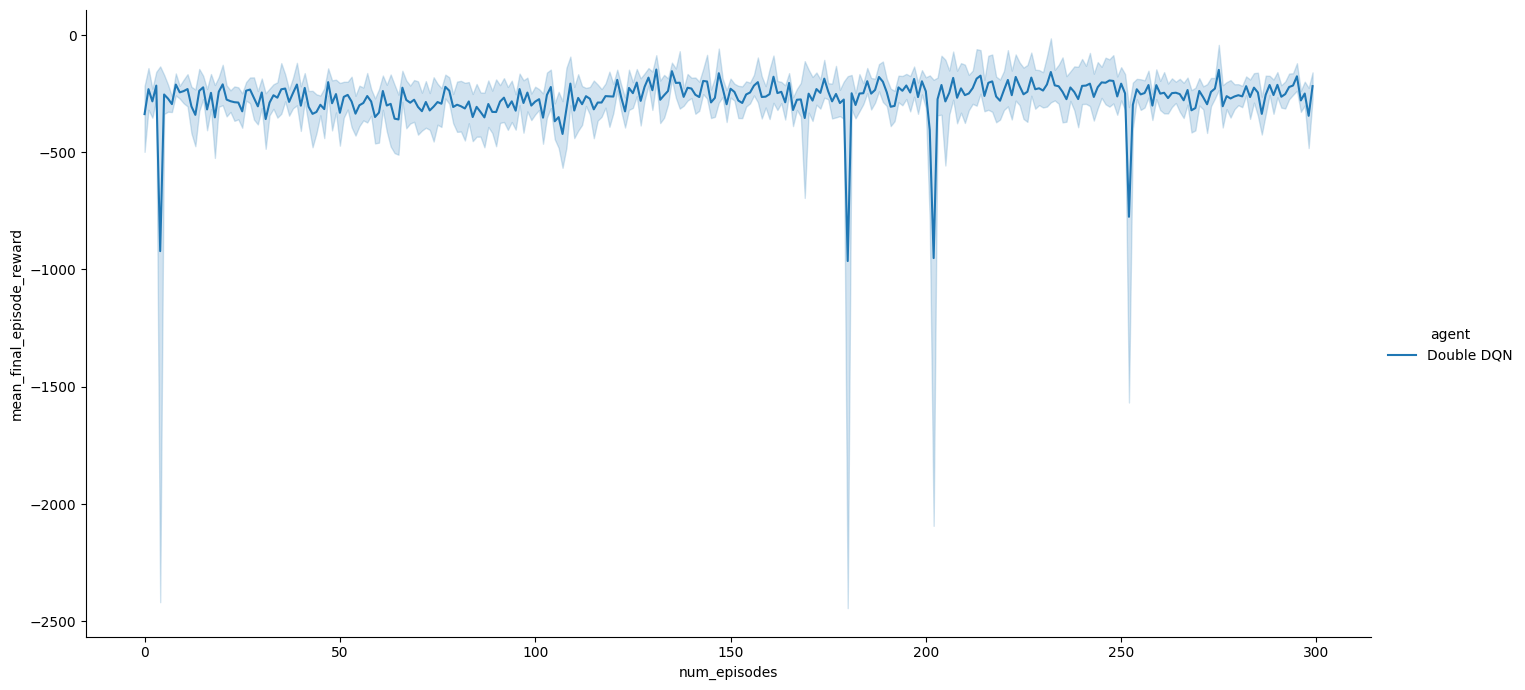

In [17]:
all_trains_result_df = pd.concat([dddqn_trains_result_df])
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", data=all_trains_result_df, height=7, aspect=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode reward: -361.2646438922682
Episode reward: -493.2093000712449
Episode reward: -435.956058310503
Episode reward: -111.68112959713041
Episode reward: -206.85049933962188


/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


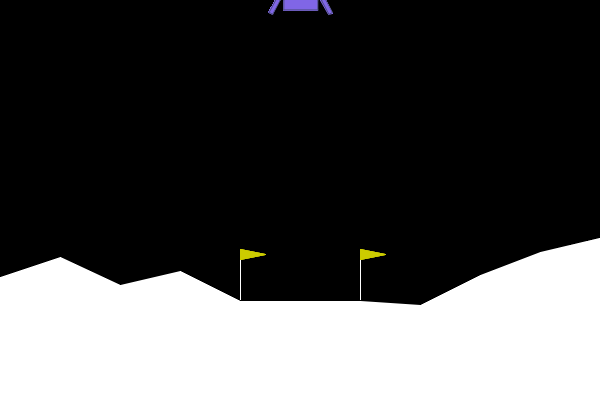

In [18]:
# Test agent
env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)

test_q_network_agent(env, online_q_network, num_episode=5)


# print('Total Reward:', total_reward)
env.render_wrapper.make_gif("Prioritized_Replay_Buffer.gif")

# Noisy Nets

In [23]:
class NoisyLayer(torch.nn.Module):
    def __init__(self, in_features, out_features, std_init=0.4):
        super(NoisyLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = torch.nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = torch.nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))

        self.bias_mu = torch.nn.Parameter(torch.empty(out_features))
        self.bias_sigma = torch.nn.Parameter(torch.empty(out_features))
        self.register_buffer('bias_epsilon', torch.empty(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / np.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / np.sqrt(self.out_features))

    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.outer(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def _scale_noise(self, size):
        x = torch.randn(size)
        return x.sign().mul_(x.abs().sqrt_())

    def forward(self, input):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return torch.nn.functional.linear(input, weight, bias)


In [20]:
class QNoisyNetwork(torch.nn.Module):
    """
    A Q-Network implemented with PyTorch.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        First fully connected layer.
    layer2 : torch.nn.Linear
        Second fully connected layer.
    layer3 : torch.nn.Linear
        Third fully connected layer.

    Methods
    -------
    forward(x: torch.Tensor) -> torch.Tensor
        Define the forward pass of the QNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int, nn_l1: int, nn_l2: int):
        """
        Initialize a new instance of QNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        nn_l1 : int
            The number of neurons on the first layer.
        nn_l2 : int
            The number of neurons on the second layer.
        """
        super(QNoisyNetwork, self).__init__()

        # TODO...

        self.layer1 = NoisyLayer(n_observations, nn_l1)
        self.layer2 = NoisyLayer(nn_l1, nn_l2)
        self.layer3 = NoisyLayer(nn_l2, n_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass of the QNetwork.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor (state).

        Returns
        -------
        torch.Tensor
            The output tensor (Q-values).
        """

        # TODO...
        x = x.to(device)

        x = self.layer1(x)
        x = torch.relu(x)

        x = self.layer2(x)
        x = torch.relu(x)

        x = self.layer3(x)

        return x

    def reset_noise(self):
        self.layer1.reset_noise()
        self.layer2.reset_noise()
        self.layer3.reset_noise()

In [21]:
def train_noisy_dqn_agent(env: gym.Env,
                                   q_network: torch.nn.Module,
                                   target_q_network: torch.nn.Module,  # Added for Double DQN
                                   optimizer: torch.optim.Optimizer,
                                   loss_fn: Callable,
                                   device: torch.device,
                                   lr_scheduler: torch.optim.lr_scheduler._LRScheduler,
                                   num_episodes: int,
                                   gamma: float,
                                   batch_size: int,
                                   replay_buffer: ReplayBuffer,  freq_update: int = 4) -> List[float]:
    episode_reward_list = []

    q_network.to(device)
    target_q_network.to(device)

    for episode_index in tqdm(range(num_episodes)):
        state, _ = env.reset()
        episode_reward = 0

        # Reset noise for the online Q-Network at the start of each episode
        q_network.reset_noise()

        for t in itertools.count():
            state_tensor = torch.tensor([state], dtype=torch.float32, device=device)

            with torch.no_grad():
                action = q_network(state_tensor).argmax(1).item()

            next_state, reward, done, _, _ = env.step(action)

            replay_buffer.add(state, action, reward, next_state, done)

            if len(replay_buffer) > batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                states_tensor = torch.tensor(states, dtype=torch.float32, device=device)
                actions_tensor = torch.tensor(actions, dtype=torch.long, device=device)
                rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=device)
                next_states_tensor = torch.tensor(next_states, dtype=torch.float32, device=device)
                dones_tensor = torch.tensor(dones, dtype=torch.float32, device=device)

                predicted_q_vals = q_network(states_tensor).gather(1, actions_tensor.unsqueeze(1)).squeeze(1)

                # Get max predicted Q-vals (for next states) from target model
                max_next_q_vals = target_q_network(next_states_tensor).max(1)[0]
                max_next_q_vals[dones] = 0.0  # Zero out the vals for terminal states
                expected_q_vals = rewards_tensor + gamma * max_next_q_vals

                # Compute loss
                loss = loss_fn(predicted_q_vals, expected_q_vals)

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()


            episode_reward += reward
            state = next_state

            if done:
                q_network.reset_noise()
                if episode_index % freq_update == 0:
                    target_q_network.load_state_dict(q_network.state_dict())
                break

        episode_reward_list.append(episode_reward)

    return episode_reward_list, q_network


In [24]:
env = gym.make('LunarLander-v2')
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

noisy_trains_result_list = [[], [], []]

online_q_network = QNoisyNetwork(n_observations, n_actions, nn_l1=64, nn_l2=64).to(device)
target_q_network = QNoisyNetwork(n_observations, n_actions, nn_l1=64, nn_l2=64).to(device)
target_q_network.load_state_dict(online_q_network.state_dict())

optimizer = torch.optim.Adam(online_q_network.parameters(), lr=1e-4)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.99, min_lr=1e-6)

replay_buffer = ReplayBuffer(capacity=100000)

loss_fn = torch.nn.MSELoss()

for train_index in range(NUMBER_OF_TRAININGS):

  episode_rewards, _ = train_noisy_dqn_agent(
      env=env,
      q_network=online_q_network,
      target_q_network=target_q_network,
      optimizer=optimizer,
      loss_fn=loss_fn,
      device=device,
      lr_scheduler=lr_scheduler,
      num_episodes=2000,
      gamma=0.99,
      batch_size=64,
      replay_buffer=replay_buffer,
      freq_update=10
  )
noisy_trains_result_list[0].extend(range(len(episode_reward_list)))
noisy_trains_result_list[1].extend(episode_reward_list)
noisy_trains_result_list[2].extend([train_index for _ in episode_reward_list])

noisy_trains_result_df = pd.DataFrame(np.array(noisy_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
noisy_trains_result_df['agent'] = 'Noisy'
torch.save(online_q_network, "online_q_network_noisy.pth")
torch.save(target_q_network, "target_q_network_noisy.pth")
env.close()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Lunar Lander
# DQN with Prioritized Replay Buffer

## Prioritized Buffer DQN

In [26]:
class PriorityQueue:
    def __init__(self):
        self._queue = []
        self._index = 0

    def push(self, item, priority):
        # The priority value, index, and item are pushed onto the queue.
        # The index is used to ensure that two items with the same priority are returned in the order they were added.
        # Notice the negative sign on priority to turn heapq into a max-heap, remove it for a min-heap.
        heapq.heappush(self._queue, (priority, self._index, item))
        self._index += 1

    def pop(self, k=1):
        # Temporarily removes the k highest priority items from the queue and returns them,
        # then re-adds them to the queue.
        if k > len(self._queue):
            k = len(self._queue)  # Ensure k does not exceed the current queue size

        popped_items = []
        for _ in range(k):
            if self._queue:  # Check if the queue is not empty
                popped_item = heapq.heappop(self._queue)[-1]
                popped_items.append(popped_item)

        # Re-add the popped items back to the queue
        for item in popped_items:
            self.push(item, priority=item[-1])

        return popped_items

    def __len__(self):
      return len(self._queue)

In [27]:
class EpsilonGreedy:
    """
    An Epsilon-Greedy policy.

    Attributes
    ----------
    epsilon : float
        The initial probability of choosing a random action.
    epsilon_min : float
        The minimum probability of choosing a random action.
    epsilon_decay : float
        The decay rate for the epsilon value after each action.
    env : gym.Env
        The environment in which the agent is acting.
    q_network : torch.nn.Module
        The Q-Network used to estimate action values.

    Methods
    -------
    __call__(state: np.ndarray) -> np.int64
        Select an action for the given state using the epsilon-greedy policy.
    decay_epsilon()
        Decay the epsilon value after each action.
    """

    def __init__(self,
                 epsilon_start: float,
                 epsilon_min: float,
                 epsilon_decay:float,
                 env: gym.Env,
                 q_network: torch.nn.Module):
        """
        Initialize a new instance of EpsilonGreedy.

        Parameters
        ----------
        epsilon_start : float
            The initial probability of choosing a random action.
        epsilon_min : float
            The minimum probability of choosing a random action.
        epsilon_decay : float
            The decay rate for the epsilon value after each episode.
        env : gym.Env
            The environment in which the agent is acting.
        q_network : torch.nn.Module
            The Q-Network used to estimate action values.
        """
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:
        """
        Select an action for the given state using the epsilon-greedy policy.

        If a randomly chosen number is less than epsilon, a random action is chosen.
        Otherwise, the action with the highest estimated action value is chosen.

        Parameters
        ----------
        state : np.ndarray
            The current state of the environment.

        Returns
        -------
        np.int64
            The chosen action.
        """

        random_float = np.random.uniform(0., 1.)
        if (random_float < self.epsilon):
            action = np.random.choice([0, 1, 2, 3])
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action = torch.argmax(self.q_network(state_tensor)).item()
        return action

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [28]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        """
        Initialize a new instance of MinimumExponentialLR.

        Parameters
        ----------
        optimizer : torch.optim.Optimizer
            The optimizer whose learning rate should be scheduled.
        lr_decay : float
            The multiplicative factor of learning rate decay.
        last_epoch : int, optional
            The index of the last epoch. Default is -1.
        min_lr : float, optional
            The minimum learning rate. Default is 1e-6.
        """
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler.

        Returns
        -------
        List[float]
            The learning rates of each parameter group.
        """
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

In [29]:
class ReplayBufferWithPriorityQueue:
    """
    A Replay Buffer with priority queue.

    Attributes
    ----------
    buffer : priority_queue

    Methods
    -------
    add(state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool)
        Add a new transition to the buffer.
    sample(batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]
        Sample a batch of transitions from the buffer.
    _len_()
        Return the current size of the buffer.
    """

    def __init__(self, capacity: int):
        """
        Initializes a ReplayBuffer instance.

        Parameters
        ----------
        capacity : int
            The maximum number of transitions that can be stored in the buffer.
        """
        self.buffer = PriorityQueue()

    def add(self, state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool, td_error: float):
        """
        Add a new transition to the buffer and sort the buffer.

        Parameters
        ----------
        state : np.ndarray
            The state vector of the added transition.
        action : np.int64
            The action of the added transition.
        reward : float
            The reward of the added transition.
        next_state : np.ndarray
            The next state vector of the added transition.
        done : bool
            The final state of the added transition.
        td_error : float
            The td_error of the added transition.
        """
        self.buffer.push((state, action, reward, next_state, done, td_error), priority = td_error)

    def sample(self, batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]:
        """
        Sample a batch of transitions from the buffer.

        Parameters
        ----------
        batch_size : int
            The number of transitions to sample.

        Returns
        -------
        Tuple[np.ndarray, float, float, np.ndarray, bool]
            A batch of batch_size transitions.
        """
        # Here, 'get first batch_size tuples from the sorted buffer'
        # returns a list of tuples (state, action, reward, next_state, done, td_error)
        # where:
        # - state  and next_state are numpy arrays
        # - action, reward and td_error are floats
        # - done is a boolean
        #
        # states, actions, rewards, next_states, dones, td_errors = zip(*self.buffer.pop(k = batch_size))
        # generates 6 tuples state, action, reward, next_state, done, td_error, each having batch_size elements.
        states, actions, rewards, next_states, dones, td_errors = zip(*self.buffer.pop(k = batch_size))
        return np.array(states), actions, rewards, np.array(next_states), dones, td_errors

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns
        -------
        int
            The current size of the buffer.
        """
        return len(self.buffer)

In [30]:
class QNetwork(torch.nn.Module):
    """
    A Q-Network implemented with PyTorch.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        First fully connected layer.
    layer2 : torch.nn.Linear
        Second fully connected layer.
    layer3 : torch.nn.Linear
        Third fully connected layer.

    Methods
    -------
    forward(x: torch.Tensor) -> torch.Tensor
        Define the forward pass of the QNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int, nn_l1: int, nn_l2: int):
        """
        Initialize a new instance of QNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        nn_l1 : int
            The number of neurons on the first layer.
        nn_l2 : int
            The number of neurons on the second layer.
        """
        super(QNetwork, self).__init__()

        # TODO...

        self.layer1 = torch.nn.Linear(n_observations, nn_l1)
        self.layer2 = torch.nn.Linear(nn_l1, nn_l2)
        self.layer3 = torch.nn.Linear(nn_l2, n_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass of the QNetwork.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor (state).

        Returns
        -------
        torch.Tensor
            The output tensor (Q-values).
        """

        # TODO...
        x = x.to(device)

        x = self.layer1(x)
        x = torch.relu(x)

        x = self.layer2(x)
        x = torch.relu(x)

        x = self.layer3(x)

        return x

In [31]:
env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n.item()
print("State space dimension is:", state_dim)
print("State upper bounds:", env.observation_space.high)
print("State lower bounds:", env.observation_space.low)
print(f"Action space size is: { action_dim }")
print("Actions are: {" + ", ".join([str(a) for a in range(env.action_space.n)]) + "}")

State space dimension is: 8
State upper bounds: [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ]
State lower bounds: [-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ]
Action space size is: 4
Actions are: {0, 1, 2, 3}


In [32]:
def train_dqn_agent(env: gym.Env,
                    q_network: torch.nn.Module,
                    optimizer: torch.optim.Optimizer,
                    loss_fn: Callable,
                    epsilon_greedy: EpsilonGreedy,
                    device: torch.device,
                    lr_scheduler: _LRScheduler,
                    num_episodes: int,
                    gamma: float,
                    batch_size: int,
                    replay_buffer: ReplayBufferWithPriorityQueue) -> List[float]:
    """
    Train the Q-network on the given environment.

    Parameters
    ----------
    env : gym.Env
        The environment to train on.
    q_network : torch.nn.Module
        The Q-network to train.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    loss_fn : callable
        The loss function to use for training.
    epsilon_greedy : EpsilonGreedy
        The epsilon-greedy policy to use for action selection.
    device : torch.device
        The device to use for PyTorch computations.
    lr_scheduler : torch.optim.lr_scheduler._LRScheduler
        The learning rate scheduler to adjust the learning rate during training.
    num_episodes : int
        The number of episodes to train for.
    gamma : float
        The discount factor for future rewards.
    batch_size : int
        The size of the batch to use for training.
    replay_buffer : ReplayBuffer
        The replay buffer storing the experiences with their priorities.

    Returns
    -------
    List[float]
        A list of cumulated rewards per episode.
    """
    episode_reward_list = []

    for episode_index in tqdm(range(1, num_episodes)):
        state, _ = env.reset()
        episode_reward = 0

        for t in itertools.count():
            # Get epislon greedy action
            action = epsilon_greedy(state)
            # Step in environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            # Calculate TD error
            state_tensor = torch.tensor(state, dtype=torch.float32, device = device)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device = device)
            predicted_q_value = q_network(state_tensor)[action].item()
            target_q_value = reward + gamma * torch.max(q_network(next_state_tensor)).item() * (1 - done)
            td_error = abs(predicted_q_value - target_q_value)
            # Store experiences
            replay_buffer.add(state, action, reward, next_state, done, -td_error)
            if (len(replay_buffer) > batch_size):
                # Sample experiences
                states, actions, rewards, next_states, dones, _ = replay_buffer.sample(batch_size)
                # Convert numpy arrays to tensors
                states_tensor = torch.tensor(states, dtype=torch.float32).to(device)
                actions_tensor = torch.tensor(actions, dtype=torch.int64).to(device)
                next_states_tensor = torch.tensor(next_states, dtype=torch.float32).to(device)
                rewards_tensor = torch.tensor(rewards, dtype=torch.float32).to(device)
                dones_tensor = torch.tensor(dones, dtype=torch.int8).to(device)
                # Set target
                y = rewards_tensor + gamma * torch.max(q_network(next_states_tensor), axis = 1).values * (1 - dones_tensor)
                y = y.unsqueeze(1)
                # Set estimate
                # y_hat = q_network(states_tensor)
                y_hat = torch.gather(q_network(states_tensor), 1, actions_tensor.view(-1,1))
                # Compute loss
                loss = loss_fn(y, y_hat)
                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
            # Accumulate rewards
            episode_reward += reward
            # Update state
            state = next_state
            # Check if done
            if (done):
                break
        episode_reward_list.append(episode_reward)
        epsilon_greedy.decay_epsilon()

    return episode_reward_list,q_network

In [34]:
#Train
env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n.item()

NUMBER_OF_TRAININGS = 1
dqn_priority_trains_result_list = [[], [], []]

for train_index in range(1):

    # Instantiate required objects
    q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

    replay_buffer = ReplayBufferWithPriorityQueue(2000)

    # Train the q-network

    episode_reward_list,trained_q_network = train_dqn_agent(env,
                                           q_network,
                                           optimizer,
                                           loss_fn,
                                           epsilon_greedy,
                                           device,
                                           lr_scheduler,
                                           num_episodes=200,
                                           gamma=0.9,
                                           batch_size=128,
                                           replay_buffer=replay_buffer)
    dqn_priority_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn_priority_trains_result_list[1].extend(episode_reward_list)
    dqn_priority_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn_priority_trains_result_df = pd.DataFrame(np.array(dqn_priority_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn_priority_trains_result_df["agent"] = "DQN with Prioritized Replay Buffer"

# Save the action-value estimation function

torch.save(q_network, "dqn_priority_q_network.pth")

env.close()

  0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

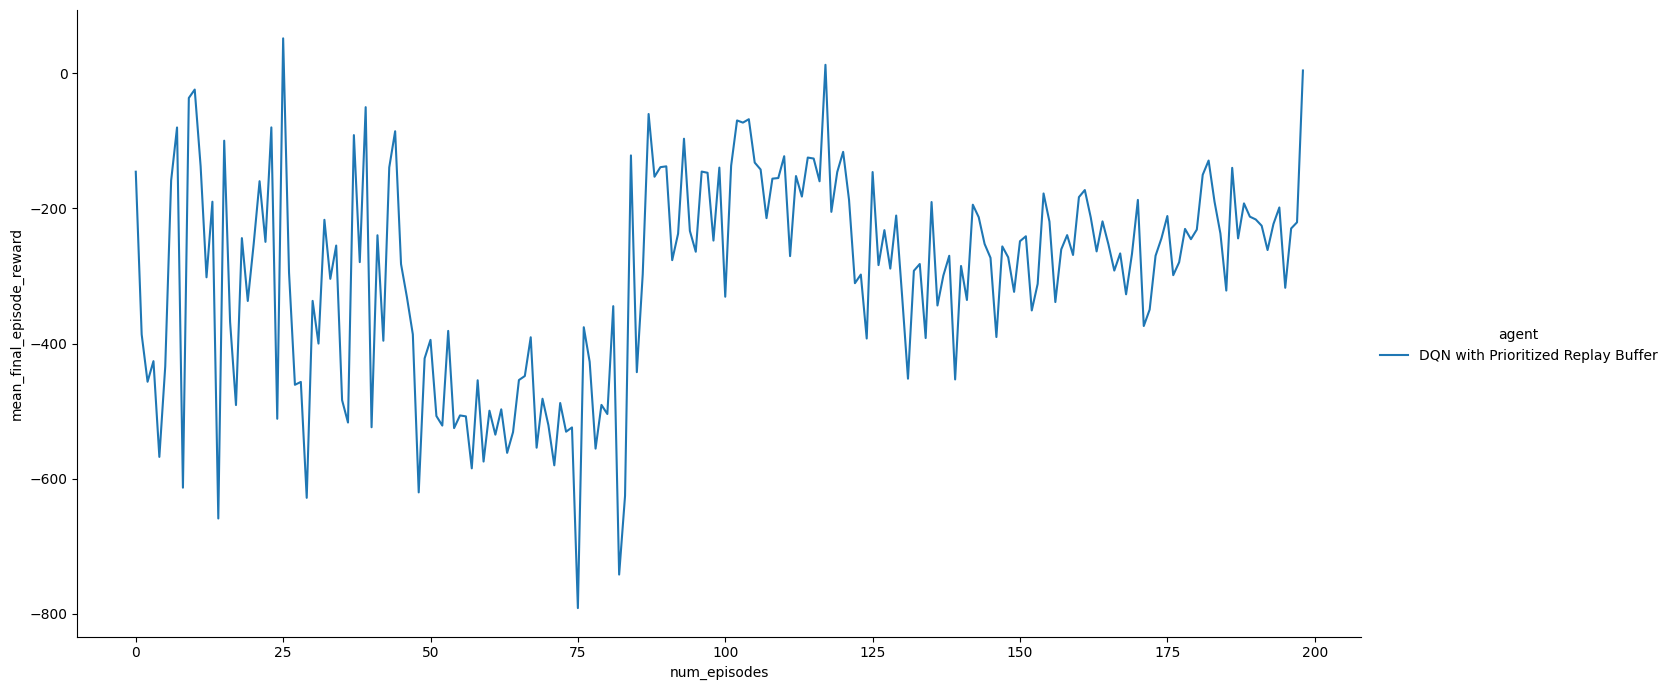

In [35]:
all_trains_result_df = pd.concat([dqn_priority_trains_result_df])
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", data=all_trains_result_df, height=7, aspect=2)

Total Reward: -8038.767569103063


/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


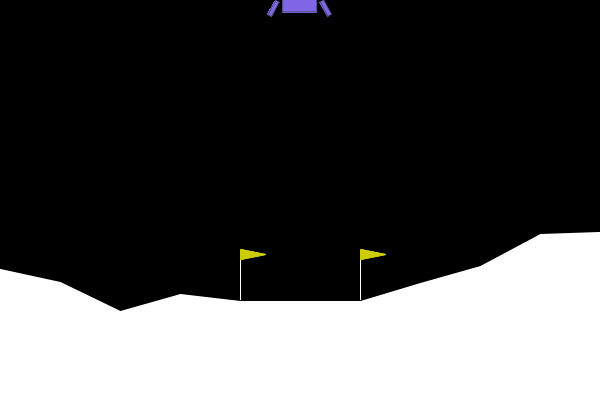

In [36]:
# Test agent
env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)

state, info = env.reset()
done = False

total_reward = 0

for t in range(150):
    env.render_wrapper.render()

    # Sample actions from the NN
    state_tensor = torch.tensor(state, device=device)
    action = torch.argmax(trained_q_network(state_tensor)).item()

    state, reward, done, truncated, info = env.step(action)

    total_reward += reward

env.close()

print('Total Reward:', total_reward)
env.render_wrapper.make_gif("Prioritized_Replay_Buffer.gif")

## Monte Carlo - this code is based on the notebook from Omar Gutierrez: https://github.com/omargup/Lunar-Lander

#### Create the environment

In [37]:
def create_env():
    return gym.make('LunarLander-v2')

#### Understanding the environment

In [38]:
def show_action_and_env_space(env):
    # Action space and environment space
    print("env.action_space", env.action_space)
    print("env.observation_space", env.observation_space)
    print("env.observation_space.high", env.observation_space.high)
    print("env.observation_space.low", env.observation_space.low)

#### Buckets
We need to discretize the environment values (observation vector); to do this, we are going to use buckets for each dimension of the observation vector. If the real value of the first dimension of the observation vector is in $[a,b]$ and if the number of buckets for that dimension is $n$, we are going to interpolate that real value into an integer in $[0,n-1]$.

In [39]:
def set_buckets_and_actions():
    number_of_buckets = (8,8,8,8,8,8,2,2) #buckets in each dimension
    number_of_actions = env.action_space.n

    #Creating a 2-tuple with the original bounds of each dimension
    state_value_bounds = list(zip(env.observation_space.low,env.observation_space.high))

    #New bound values for each dimension
    state_value_bounds[0] = [-0.5,0.5]      #Position x
    state_value_bounds[1] = [-1,1]    #Position y
    state_value_bounds[2] = [-1,1]        #vel x
    state_value_bounds[3] = [-1,1]    #vel y
    state_value_bounds[4] = [-1,1]        #angle
    state_value_bounds[5] = [-1,1]        #angular vel
    state_value_bounds[6] = [0,1]
    state_value_bounds[7] = [0,1]

    return number_of_buckets, number_of_actions, state_value_bounds



In [40]:
def bucketize(state):
    bucket_indexes = []
    for i in range(len(state)):
        if state[i] <= state_value_bounds[i][0]:
            bucket_index = 0
        elif state[i] >= state_value_bounds[i][1]:
            bucket_index = number_of_buckets[i] - 1
        else:
            bound_width = state_value_bounds[i][1] - state_value_bounds[i][0]
            offset = (number_of_buckets[i]-1) * state_value_bounds[i][0]/bound_width
            scaling = (number_of_buckets[i]-1) / bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indexes.append(bucket_index)
    return tuple(bucket_indexes)

#### Create the Q-table

In [41]:
def initialize_q_table():
    return np.zeros(number_of_buckets + (number_of_actions,))

#### Create Returns_table

In [42]:
def initialize_visits_table():
    return np.zeros(number_of_buckets + (number_of_actions,))

In [43]:
def decay_function(episode):
    return max(min_epsilon, min(max_epsilon, 1.0 -
                              math.log10((episode + 1) / (total_train_episodes*0.1))))

In [44]:
def choose_action(q_table, bucket_state, epsilon):
    if (np.random.random() <= epsilon):
        return env.action_space.sample() #Exploration
    else:
        return np.argmax(q_table[bucket_state]) #Eplotation

In [45]:
# ******* Generate an episode following pi: S0, A0, R1, ...S_T-1,A_T-1,R_T
def Generate_episode(epsilon, q_table, max_env_steps):
    # Control variables
    total_reward = 0
    done = False

    trayectory = []

    # Initialize S
    # Reset the environment getting the initial state
    state,info = env.reset()
    bucket_state = bucketize(state)

    # Loop for each step of episode:
    for step in range(max_env_steps):
            #print("step ", step)

        # Choose A from S using a soft policy derived from Q (e.g., epsilon-greedy)
        action = choose_action(q_table, bucket_state, epsilon)

        # Take the action A, observe R, S'
        new_state, reward, done, trunc,info = env.step(action)
        bucket_new_state = bucketize(new_state)

        trayectory.append([bucket_state, action, reward])

        # new_state is now the current state
        bucket_state = bucket_new_state

        total_reward += reward

        # if done, finish the episode
        if done:
            break

    return trayectory, total_reward

---

# The Monte Carlo algorithm

* Initialize $Q(s,a) \in \mathbb{R}$ arbitrarily ($Q(S,A) = 0$, for all $S,A$ in this case)
* $Returns(s,a) \longleftarrow$ empty list for all $S, A$
* Loop for each episode:
    * Generate an episode following $\pi$: $S_0, A_0, R_1, ..., S_{T-1}, A_{T-1}, R_T$
    * $G \longleftarrow 0$
    * Loop for each step of episode, $t=T-1, T-2, ..., 0$:
        * $G \longleftarrow \gamma G + R_{t+1}$
        * Unless the pair $S_t, A_t$ appears in $S_0, A_0, S_1, A_1, ..., S_{t-1}, A_{t-1}$:
            * Append $G$ to $Returns(S_t,A_t)$
            * $Q(S_t,A_t)$ $\longleftarrow$ average($Returns(S_t,A_t)$)
            * $A* \longleftarrow argmax_aQ(S_t,a)$
            * For all $a \in A(S_t)$:
                * if $a = A*: \pi (a|S_t) \longleftarrow 1 - \epsilon + \epsilon / A(S_t)$
                * else if $a \neq A*: \pi (a|S_t) \longleftarrow \epsilon / A(S_t)$
                

In [46]:
def Monte_Carlo():
    # ******* Initialize 𝑄(s,a) arbitrarily.
    q_table = initialize_q_table()
    #print("Q_Table shape: ", q_table.shape)

    # ******* Initialize Returns(s,a) empty list
    # initialize visits_counter instead (for incremental implementation of the average)
    visits_counter = initialize_visits_table()

    rewards = []

    max_env_steps = env._max_episode_steps   #1000 in LunarLander
    #print("Max env steps: ", max_env_steps)



    # ******* Loop for each episode:
    for episode in range(total_train_episodes):
        #print("\n\n ***Episode*** ", episode)

        # ******* Generate an episode following pi: S0, A0, R1, ...S_T-1,A_T-1,R_T
        #Update epsilon
        epsilon = decay_function(episode)
        #print("Epsilon ", epsilon)
        trayectory ,total_reward = Generate_episode(epsilon, q_table, max_env_steps)

        # ******* G <-- 0
        G = 0


        # ******* Loop for each step of episode: t = T-1, T-2, ..., 0
        for t in reversed(range(len(trayectory))):
            #print("\n step", t)
            s_t, a_t, r_t = trayectory[t]
            # ******* G <-- gamma*G + R_{t+1}
            G = gamma*G + r_t
            #print("G ", G)

            # ******* Unless the pair S_t,A_t appears in S_0,A_0,R_1, ...,S_{t-1},A_{t-1}:
            if not [s_t, a_t] in [[x[0], x[1]] for x in trayectory[0:t]]:
                #print("YES First visit ", s_t, a_t)

                # ******* Append G to Returns(S_t,A_t)
                # ******* Q(S_t,A_t) <-- average(Returns(S_t,A_t))
                # Using incremental implementation: Q(S_t,A_t)= Q_n <-- Q_n + (1/n)*(G_n - Q_n)
                visits_counter[s_t][a_t] += 1
                #print("visits_counter ", visits_counter[s_t][a_t])
                #print("old Q value ", q_table[s_t][a_t])
                q_table[s_t][a_t] += (G - q_table[s_t][a_t]) / visits_counter[s_t][a_t]
                #print("new Q value ", q_table[s_t][a_t])
            #else: print("NO first visit ", s_t, a_t)


        #print("total_reward ", total_reward)

        if episode % 50 == 0:
            rewards.append(total_reward)
            print("Episode {}, epsilon {:5.4f}, reward {:6.2f}".format(episode,epsilon,total_reward))

    rewards.append(total_reward)
    print("Episode {}, epsilon {:5.4f}, reward {:6.2f}".format(episode,epsilon,total_reward))
    return q_table, rewards

---

## Getting Q-Learning training plots

#### Running Q-Learning algorithm n time - or just once in this case

In [47]:
n_times = 1
total_train_episodes = 4000
gamma = 0.99
max_epsilon = 1.0
min_epsilon = 0.01

env.close()
env = create_env()
#env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")
number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions()

MC_tables = []
MC_rewards = []

for number in range(n_times):
    print("\n ********** Training number ", number)
    q_table,rewards = Monte_Carlo()
    MC_tables.append(q_table)
    MC_rewards.append(rewards)


 ********** Training number  0
Episode 0, epsilon 1.0000, reward -108.01
Episode 50, epsilon 1.0000, reward -215.90
Episode 100, epsilon 1.0000, reward -541.10
Episode 150, epsilon 1.0000, reward -101.76
Episode 200, epsilon 1.0000, reward -364.38
Episode 250, epsilon 1.0000, reward -302.51
Episode 300, epsilon 1.0000, reward -263.90
Episode 350, epsilon 1.0000, reward -243.56
Episode 400, epsilon 0.9989, reward -113.07
Episode 450, epsilon 0.9479, reward -192.60
Episode 500, epsilon 0.9022, reward -186.66
Episode 550, epsilon 0.8609, reward -124.65
Episode 600, epsilon 0.8232, reward -111.19
Episode 650, epsilon 0.7885, reward -44.44
Episode 700, epsilon 0.7563, reward   3.66
Episode 750, epsilon 0.7264, reward -80.86
Episode 800, epsilon 0.6984, reward -80.88
Episode 850, epsilon 0.6721, reward -167.69
Episode 900, epsilon 0.6473, reward -325.96
Episode 950, epsilon 0.6239, reward -151.57
Episode 1000, epsilon 0.6016, reward -149.41
Episode 1050, epsilon 0.5805, reward -301.41
Episo

#### Saving average reward and Q-tables

In [48]:
MC_mean = np.mean(np.array(MC_rewards),axis=0)
#print(MC_mean.shape)
np.save('MC_mean', MC_mean)
np.save('MC_tables', MC_tables)

#### Plotting Q-Learning rewards

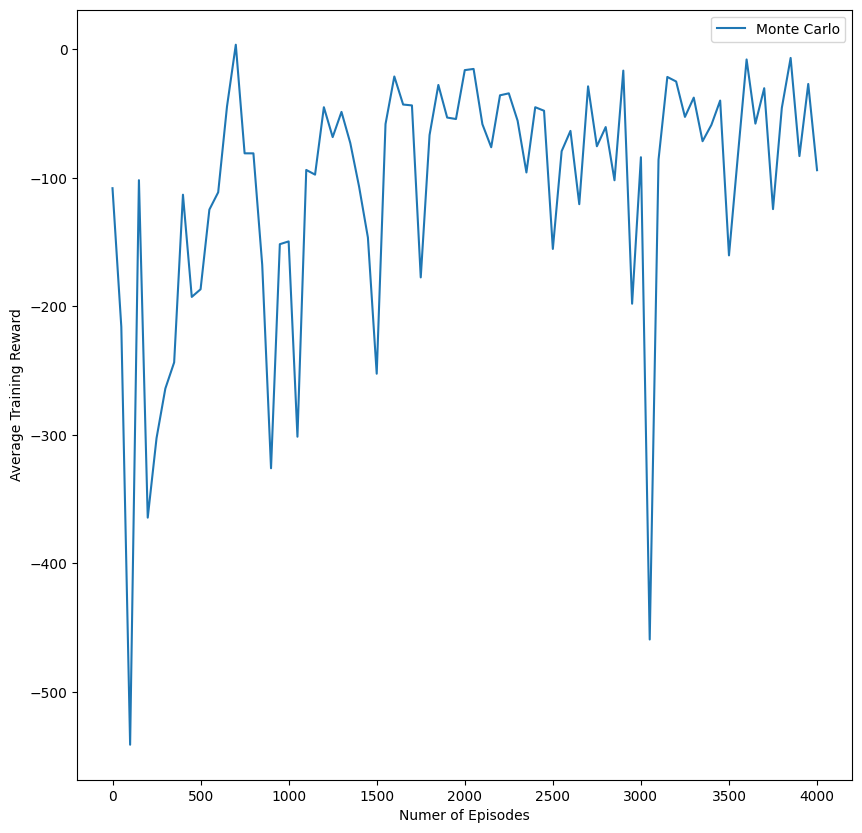

In [49]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.linspace(0, total_train_episodes, MC_mean.size)

plt.rcParams['figure.figsize'] = (10.0, 10.0)

plt.plot(x, MC_mean, label='Monte Carlo')
plt.ylabel("Average Training Reward")
plt.xlabel("Numer of Episodes")




# Add a legend
plt.legend()

# Show the plot
plt.show()

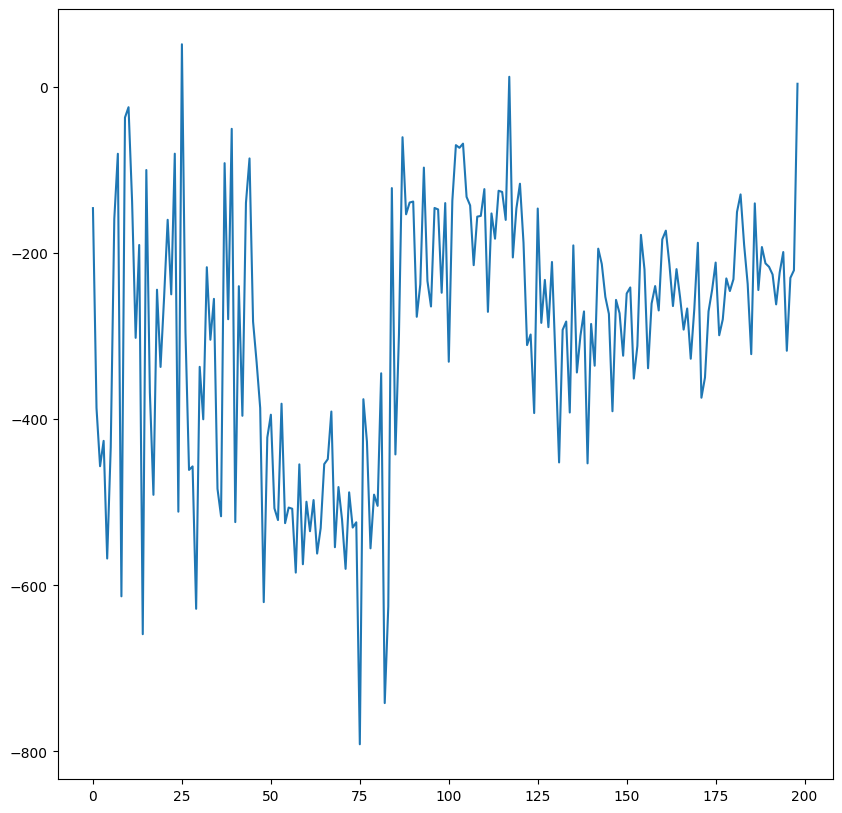

In [50]:
plt.plot(all_trains_result_df["num_episodes"],all_trains_result_df["mean_final_episode_reward"])

---

## Experiments

In [51]:
#env = create_env()
q_tables = np.load('MC_tables.npy')
q_table = q_tables[0]

number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions()

### Test Simulations

##### Monte Carlo Simulations

In [52]:
#env = create_env()
#env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")
env.close()
env = create_env()
total_test_episodes = 100
q_tables = np.load('MC_tables.npy')
q_table = q_tables[0]

max_env_steps = env._max_episode_steps
number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions()

###Variables that we store later for analysis
rewards_MC = []
finalXPositions = []
actionChangeRates_MC = []

# ******* Loop for each episode:
for episode in range(total_test_episodes):
    #print("***Episode*** ", episode)

    # Control variables
    total_rewards = 0
    done =  False

    # ******* Initialize S
    # Reset the environment getting the initial state
    state,info = env.reset()
    bucket_state = bucketize(state)

    prev_action = 0
    action_counter = 0

    # *******Loop for each step of episode:
    for step in range(max_env_steps):
        #env.render()
        #print(state)
        bucket_state = bucketize(state)
        #******* Choose A from S using policy derived from Q (greedy in this case)
        action = choose_action(q_table, bucket_state, 0)

        # ******* Take the action A, observe R, S'
        new_state, reward, done, trunc,info = env.step(action)
        bucket_new_state = bucketize(new_state)

        # new_state is now the current state
        state =  new_state

        #Action Change counter:
        if action != prev_action:
          action_counter += 1


        total_rewards += reward

        prev_action = action

        if done:
            #append to analysis arrays
            rewards_MC.append(total_rewards)

            finalXPos = state[0]
            finalXPositions.append(finalXPos)
            actionChangeRates_MC.append(action_counter / step)

            #print("Score ", total_rewards)

            break

env.close()
print("\nAverage score " + str(sum(rewards_MC)/total_test_episodes))


Average score -40.24817555098871


##### Prioritized DQN Simulations

In [53]:
###Variables that we store later for analysis
rewards_DQN = []
finalXPositions = []
actionChangeRates_DQN = []

# ******* Loop for each episode:
for episode in range(total_test_episodes):
    #print("***Episode*** ", episode)

    # Control variables
    total_rewards = 0
    done =  False

    # ******* Initialize S
    # Reset the environment getting the initial state
    state,info = env.reset()
    bucket_state = bucketize(state)

    prev_action = 0
    action_counter = 0

    # *******Loop for each step of episode:
    for step in range(max_env_steps):
        #env.render()
        state_tensor = torch.tensor(state, device=device)
        action = torch.argmax(trained_q_network(state_tensor)).item()

        new_state, reward, done, trunc,info = env.step(action)

        # new_state is now the current state
        state =  new_state

        #Action Change counter:
        if action != prev_action:
          action_counter += 1


        total_rewards += reward

        prev_action = action

        if done:
            #append to analysis arrays
            rewards_DQN.append(total_rewards)

            #finalXPos = state[0]
            #finalXPositions.append(finalXPos)
            actionChangeRates_DQN.append(action_counter / step)

            #print("Score ", total_rewards)

            break

env.close()
print("\nAverage score " + str(sum(rewards_DQN)/total_test_episodes))


Average score -241.07411366835117


## x-position distribution

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

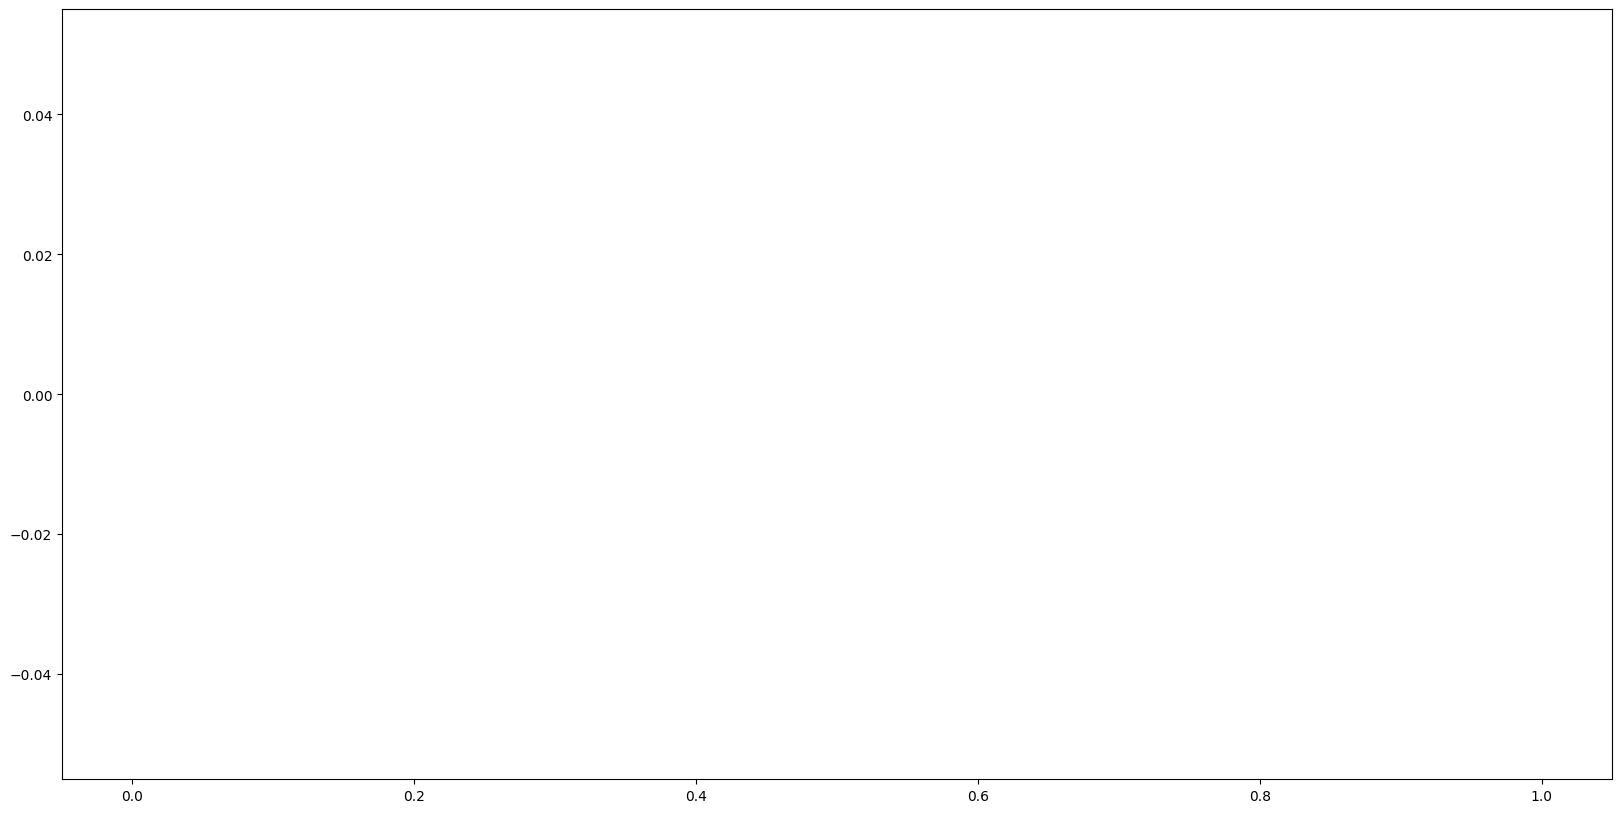

In [54]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.hist(finalXPositions,bins=20)

## Spread of the Final Rewards

In [55]:
#Variances:
STD_MC = np.std(rewards_MC)
STD_DQN = np.std(rewards_DQN)
print(f"Standard Deviation Monte Carlo: {STD_MC}")
print(f"Standard Deviation Prioritized DQN: {STD_DQN}")

Standard Deviation Monte Carlo: 82.11878078604448
Standard Deviation Prioritized DQN: 69.82948393055469


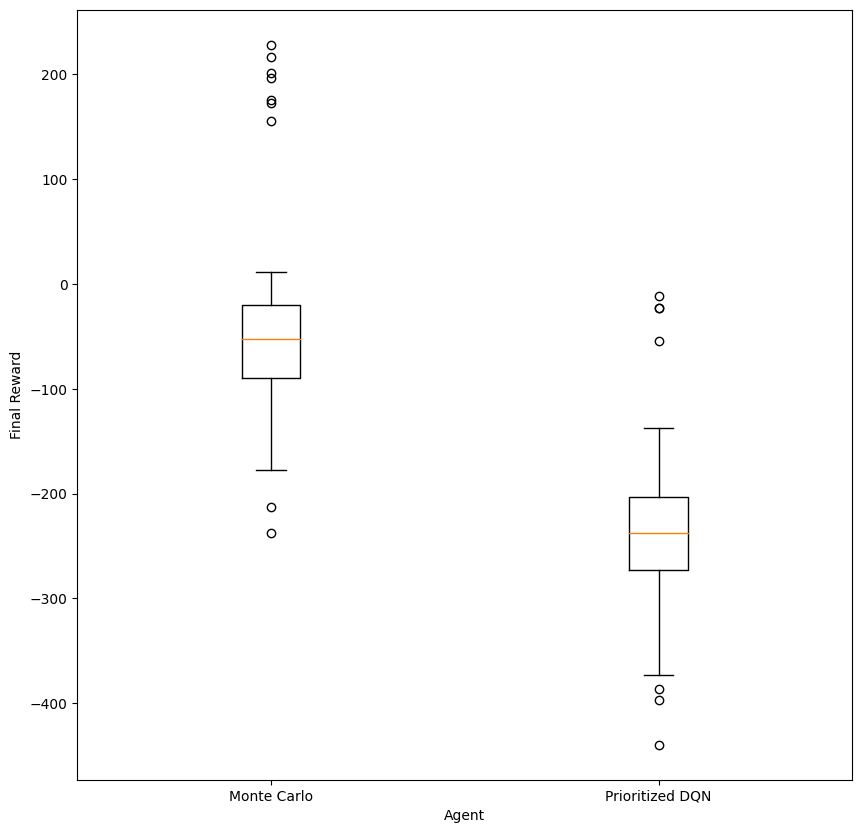

In [56]:
# Build the plot
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.boxplot([rewards_MC,rewards_DQN])
plt.xticks([1, 2], [ 'Monte Carlo', 'Prioritized DQN'])
plt.xlabel("Agent")
plt.ylabel("Final Reward")
plt.show()

## Rate of Action Change

Text(0.5, 0, 'Agent')

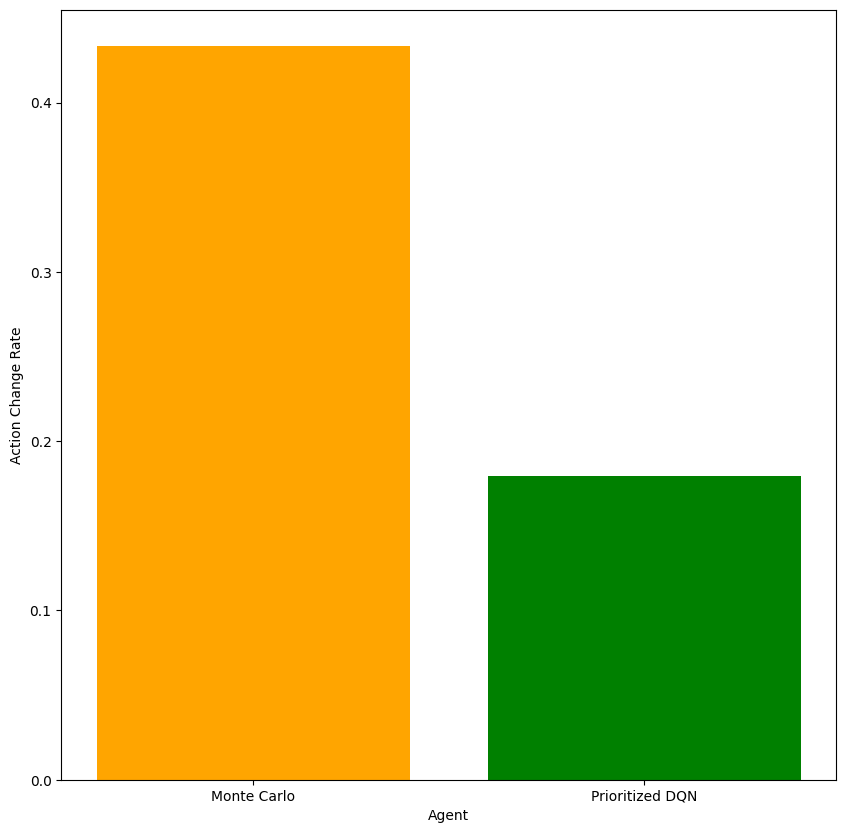

In [57]:
#print(actionChangeRates_DQN)
plt.bar(["Monte Carlo","Prioritized DQN"],[np.mean(actionChangeRates_MC),np.mean(actionChangeRates_DQN)],color=["orange","green"] )
plt.ylabel("Action Change Rate")
plt.xlabel("Agent")

## Wind and Turbulence Introduction

In [58]:

total_test_episodes = 10
q_tables = np.load('MC_tables.npy')
q_table = q_tables[0]

wind_rewards = []

max_env_steps = env._max_episode_steps
number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions()

for windval in [0,10,20,30]:
  env.close()
  env = gym.make("LunarLander-v2", continuous=False, enable_wind=True,wind_power=windval)

  ###Variables that we store later for analysis
  rewards = []

  # ******* Loop for each episode:
  for episode in range(total_test_episodes):
      #print("***Episode*** ", episode)

      # Control variables
      total_rewards = 0
      done =  False

      # ******* Initialize S
      # Reset the environment getting the initial state
      state,info = env.reset()
      bucket_state = bucketize(state)

      prev_action = 0
      action_counter = 0

      # *******Loop for each step of episode:
      for step in range(max_env_steps):
          #env.render()
          #print(state)
          bucket_state = bucketize(state)
          #******* Choose A from S using policy derived from Q (greedy in this case)
          action = choose_action(q_table, bucket_state, 0)

          # ******* Take the action A, observe R, S'
          new_state, reward, done, trunc,info = env.step(action)
          bucket_new_state = bucketize(new_state)

          # new_state is now the current state
          state =  new_state

          #Action Change counter:
          if action != prev_action:
            action_counter += 1


          total_rewards += reward

          prev_action = action

          if done:
              #append to analysis arrays
              rewards.append(total_rewards)

              #print("Score ", total_rewards)

              break
  env.close()
  print(f"\nAverage score at windpower {windval}: " + str(sum(rewards)/total_test_episodes))
  wind_rewards.append(sum(rewards)/total_test_episodes)





Average score at windpower 0: -40.93308248293145

Average score at windpower 10: -119.65025584412714

Average score at windpower 20: -151.37034346384127

Average score at windpower 30: -243.9923854468014


/usr/local/lib/python3.10/dist-packages/gymnasium/envs/box2d/lunar_lander.py:253: UserWarning: WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: 30)
  warnings.warn(


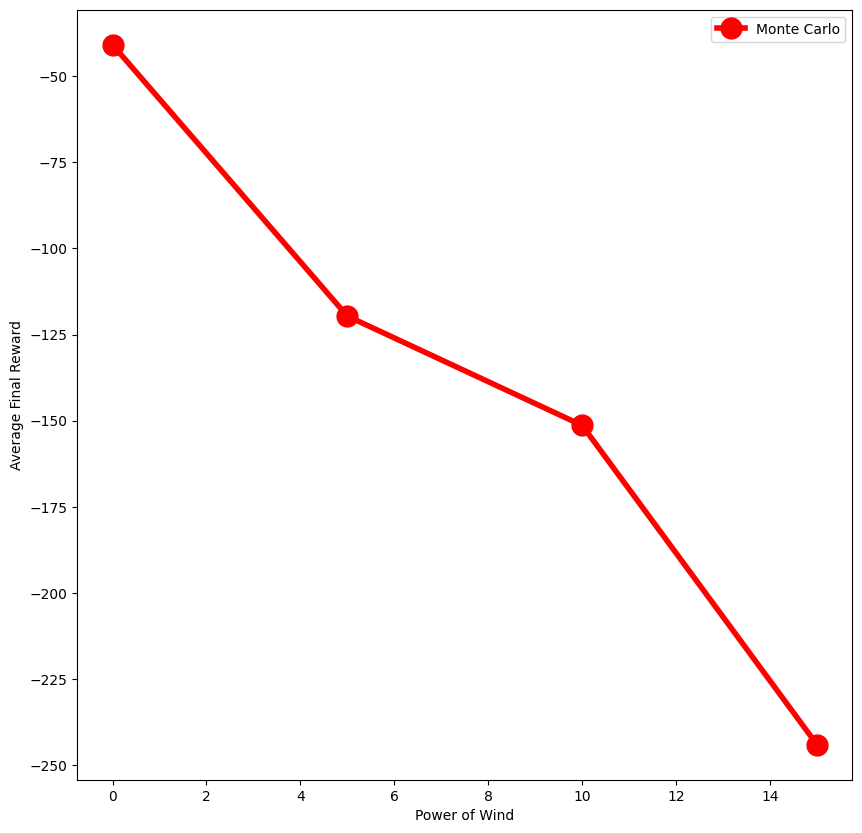

In [59]:
plt.plot([0,5,10,15],wind_rewards,linewidth=4,color='red',marker=".",markersize=30,label="Monte Carlo")
plt.xlabel("Power of Wind")
plt.ylabel("Average Final Reward")
plt.legend()

## Visualizing the Monte-Carlo Method at work

12.927135123102843


/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


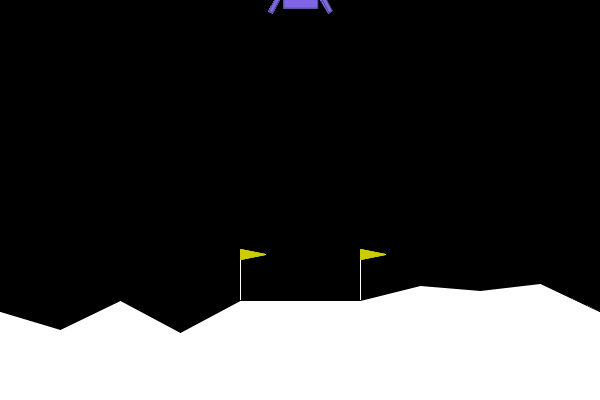

In [60]:
# Naive policies
import gymnasium as gym
env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)



state,info = env.reset()
done = False


total_rew = 0
for t in range(300):
    env.render_wrapper.render()

    # action = np.array([-1., 0.])
    # action = np.array([0., 0.])
    #action = env.action_space.sample()   # Random policy
    bucket_state = bucketize(state)
    action = choose_action(q_table, bucket_state, 0)

    state, reward, done, truncated,info = env.step(action)

    total_rew += reward

    if done:
      break

print(total_rew)

env.close()
env.render_wrapper.make_gif("lab7_ex4_explore")
